# Helmholtz 1D Tests & Illustrations
In this experiment we use a small domain (8 points) with a small $kh=0.1$, as the final grid on the large domain will still have a small $kh$ to yield a good discretization.

In [323]:
import logging
import numpy as np
import helmholtz as hm
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from numpy.linalg import norm

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Relaxed Test Vectors

In [324]:
n = 8
kh = 0.1
nc = 2
num_examples = 10
num_sweeps = 10
aggregate_size = 4
a = hm.linalg.helmholtz_1d_operator(kh, n)

# Generate relaxed test matrix.
level = hm.multilevel.Level(a)
x = hm.multilevel.random_test_matrix((n, ), num_examples=num_examples)
b = np.zeros_like(x)
print("Kaczmarz sweeps starting from rand[-1,1]")
x, conv_factor = hm.multilevel.relax_test_matrix(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
print("conv_factor {:.3f}".format(conv_factor))

Kaczmarz sweeps starting from rand[-1,1]
DEBUG        0 |e| 8.24990483e-02 |r| 1.42861539e-01
DEBUG        1 |e| 7.03265198e-02 |r| 6.43011485e-02 (0.45009)
DEBUG        2 |e| 6.59429765e-02 |r| 3.92875523e-02 (0.61099)
DEBUG        3 |e| 6.35303121e-02 |r| 2.67675084e-02 (0.68132)
DEBUG        4 |e| 6.18057477e-02 |r| 2.21573645e-02 (0.82777)
DEBUG        5 |e| 6.04627738e-02 |r| 1.85818593e-02 (0.83863)
DEBUG        6 |e| 5.93765588e-02 |r| 1.60162588e-02 (0.86193)
DEBUG        7 |e| 5.84754078e-02 |r| 1.40197044e-02 (0.87534)
DEBUG        8 |e| 5.77213253e-02 |r| 1.26773695e-02 (0.90425)
DEBUG        9 |e| 5.70827592e-02 |r| 1.15977133e-02 (0.91484)
DEBUG       10 |e| 5.65396542e-02 |r| 1.06365358e-02 (0.91712)
conv_factor 0.917


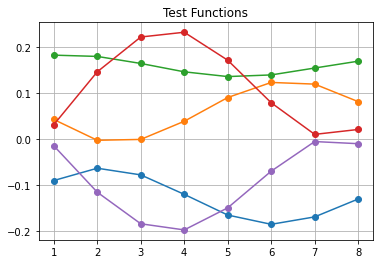

In [325]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:,i], '-o')
plt.grid(True);
plt.title("Test Functions");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

In [326]:
print("Theoretial #points per period {:.2f}".format(2*np.pi/kh))

Theoretial #points per period 62.83


### Coarse Variables by SVD on an Aggregate

In [327]:
# Generate coarse variables (R) based on a window of x.
x_aggregate_t = x[:aggregate_size].transpose()
r, s = hm.bootstrap.create_coarse_vars(x_aggregate_t, n, nc)
print("Singular values", s)

Singular values [0.66 0.3  0.09 0.  ]


In [328]:
print("%unexplained energy / interpolation error {:.3f}".format(
    (sum(s[2:]**2)/sum(s**2))**0.5))

%unexplained energy / interpolation error 0.118


In [329]:
rr = r.toarray()[:2, :4]

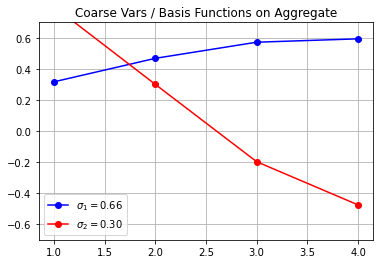

In [330]:
colors = ["b", "r"]
for i, color in enumerate(colors):
    plt.plot(np.arange(1, 5), rr[i], '{}o-'.format(color[i  % len(color)]), label="$\sigma_{" + str(i+1) + "} = " + "{:.2f}".format(s[i]) + "$")
plt.ylim([-0.7, 0.7]);
plt.legend(loc="lower left");
plt.grid(True);
plt.title("Coarse Vars / Basis Functions on Aggregate");

### Identifying Neighborhoods Algebraically

In [335]:
# xc = r.dot(x)
# xc_t = xc.transpose()

# # Measure distance between x of an aggregate and xc.
# d = sklearn.metrics.pairwise.cosine_similarity(x_aggregate_t.transpose(), xc_t.transpose())
# print("x[aggregate] - xc cos similarity")
# print(d.transpose())

x[aggregate] - xc cos similarity
[[ 0.65  0.95  0.98  0.93]
 [ 0.75  0.28 -0.15 -0.34]
 [ 0.78  0.73  0.67  0.7 ]
 [-0.01  0.43  0.75  0.9 ]]


In [332]:
print("Test Matrix dimension: ", x.shape)

Test Matrix dimension:  (8, 10)


In [334]:
xt = x.transpose()
d = sklearn.metrics.pairwise.cosine_similarity(x, x)
print("x-x cos similarity")
print(d)

x-x cos similarity
[[1.   0.81 0.52 0.37 0.41 0.6  0.83 0.95]
 [0.81 1.   0.91 0.78 0.69 0.64 0.62 0.75]
 [0.52 0.91 1.   0.96 0.87 0.69 0.48 0.52]
 [0.37 0.78 0.96 1.   0.96 0.78 0.5  0.46]
 [0.41 0.69 0.87 0.96 1.   0.92 0.66 0.56]
 [0.6  0.64 0.69 0.78 0.92 1.   0.89 0.78]
 [0.83 0.62 0.48 0.5  0.66 0.89 1.   0.96]
 [0.95 0.75 0.52 0.46 0.56 0.78 0.96 1.  ]]


For this small $kh$ value, we see that the nearest neighbors are indeed gometric neighbors.